# Using Machine Learning to Build a Car Price Predictor
> A pricing predictor for new listings on <a href="https://www.cars.com/">cars.com</a>.

- toc: true 
- badges: true
- comments: true
- sticky_rank: 1
- categories: [end-to-end-ml-development-project, web-scraping, exploratory-data-analysis, project, machine-learning]

## Overview

In [1]:
#hide
from IPython.display import Image

import pandas as pd

### Background
The hypothetical client is in the car-loan financing business and targets customers looking to purchase a vehicle from the emarketplace cars.com. The client only serves two US cities - Austin, TX and Seattle, WA - and immediately surrounding areas (within a 20 mile range of a highly populated zip code in each city - [78745 in Austin](http://localistica.com/usa/tx/zipcodes/most-populated-zipcodes/) and [99208 and 99052 in Seattle](http://localistica.com/usa/wa/zipcodes/most-populated-zipcodes/)).

Currently a financing package is developed using in-house business rules taking into account listing attributes such as exterior styling, transmission speed, tank capacity, etc. These factors are used to approximate a listing price. Even through cars.com lists a price, the client needs their own approximation since it is their financing that will be offered to the customer. At present, the client focuses on new-vehicle financing only, up to a price of `$`45,000, and so wants to market itself as a competitor to cars.com for financing listings on that platform.

### Motivation
The client develops an estimate of the value (price) of the listing and develops a financing package based on this price, using knowledge of the field. Based on this package, the client decides if they want to proceed with the purchase. If so, they'll buy the car from cars.com but take the financing package from our client and cover the difference in estimated and true price themselves.

The client has noticed that customers are more aggressively re-negotiating financing terms for listings whose prices are under-estimated. This results in them (client) needing to re-structure the financing and make a more generous offer than warranted in order to keep the prospective customer happy and willing to proceed with purchase through them rather than through a competitor. This re-structuring represents a loss to the client. It is also required for over-estimated prices but, with less pressure from the customer, a more reasonable re-structuring is possible without incurring such a heavy loss.

So, the client wants to explore the use of ML to cut down on their re-structuring losses. They hope the result is fewer under-predicted prices thereby cutting their re-structuring losses. As factors important to predicting the price are currently used to develop a financing package, the client wants the ML price prediction service to return interpretable predictors. To this end, they are on the lookout for a ML-based pricing service to (a) estimate car listing prices and (b) use the factors identified as being important predictors of the price to build their financing package. If they find a suitable service, they will replace all in-house business rule-based pricing with the ML-based approach.

### Costs Involved
From historical experience in dealing with customers, the client has observed that the re-structuring problem appears when the client's estimated price is different from the true price by more than `$`5,000. So, they are willing to pay 15% of the true price for predictions within the acceptable (tolerable) range of `$`5,000 above or below the true price. However, they will charge the pricing service for intolerable errors (larger than `$`5,000) as explained above - 40% for intolerable under- and 10% for intolerable over-predictions of the price.

### Objective
This project develops a first version of such an ML based service and estimates the return earned (or lost) from developing an ML-based listing pricing service to make predictions on listings from cars.com. The focus is on using the Python programming language for the ML development workflow covering data acquisition to generatiion of price predictions. Deploying the developed ML model is out of scope for this prototype project.

## Acquiring Data from cars.com

When retrieving listings for data from cars.com, the following search field values were submitted
1. type of car (click on required item in dropdown menu) was set to "New"
2. Make (click on required item in dropdown menu) and select All Makes
3. maximum acceptable price (click on required item in dropdown menu) and specify a budget of `$`45,000
4. zip code is set to the zip codes of interest (78745, 99208, 99052)
5. radius can left at the default value of 20 miles as required

From the results, the listing IDs were scraped from the cars.com homepage. These are the IDs for listings whose details are to be retrieved. This ID will be used to assemble the web url of each listing. A smaller number of pages of results were available for the two zip codes in Seattle. From the assembled web urls, 29 pages worth of listings (100 listings per page) were scraped for Austin and 22 pages were scraped for Seattle. Scraping was done using the [`bs4`](https://en.wikipedia.org/wiki/Beautiful_Soup_(HTML_parser)) library and [Selenium web testing](https://en.wikipedia.org/wiki/Selenium_(software)) framework.

## Cleaning Data

The following steps were followed to clean the data in the individual columns of raw data scraped from cars.com
1. Any rows without a listing title were dropped.
2. The tank volume column was cleaned by removing the units (`L`) and change the column from a string to a float, as volumes are not necessarily integers.
3. The year was extracted from the title, as an integer.
4. The make and model were split out of a combined column, into separate string columns.
5. The city and state were extracted from the listing address.
6. Transmission speed was extracted from the `Transmission` column.
7. The comma from `Mileage` was removed allowing it to be used as a numeric feature.
8. Highway and City MPG (Miles Per Gallon) were combined into a single MPG column.

## Overall Division of Data for ML Model Development

After the full dataset was scraped and cleaned, it was time to go through the ML development workflow. Before starting this, the data was split into an overall training and testing split, following an 80%-20% division. This overall training data (80% of overall data) was used to train the ML model. After this was completed, the unseen 20% of the data (the testing data) was only used for evaluating the performance on the trained ML model. If the test set was used to score the ML model's predictions, then the ML model might learn its best parameters based exclusively on the testing data and would not generalize well to out-of-sample (or unseen) data.

In order to avoid this *learning of the test split*, the test split was set aside to be treated as the unseen data and the overall training split was further sub-divided into a smaller training and validation split - in a simple workflow, the ML model is trained using this smaller training split and then scored on the validation split. After several iterations of ML model training, the best model is selected and then trained on the overall training split. It is then used only once to make and score predictions on the overall test split, which has not been seen thus far in the workflow.

During ML model development, training data (or training split, or training set) will refer to the smaller training data. During model evaluation, training data will refer to the overall training data.

## Exploratory Data Analysis and Filtering

### Target Distribution

The dependent variable here is the regression target or the listing price. The distribution of this column from the data (varible) is shown below

<img src="cpp/target_histogram.png" alt="Drawing" style="width: 300px;"/>

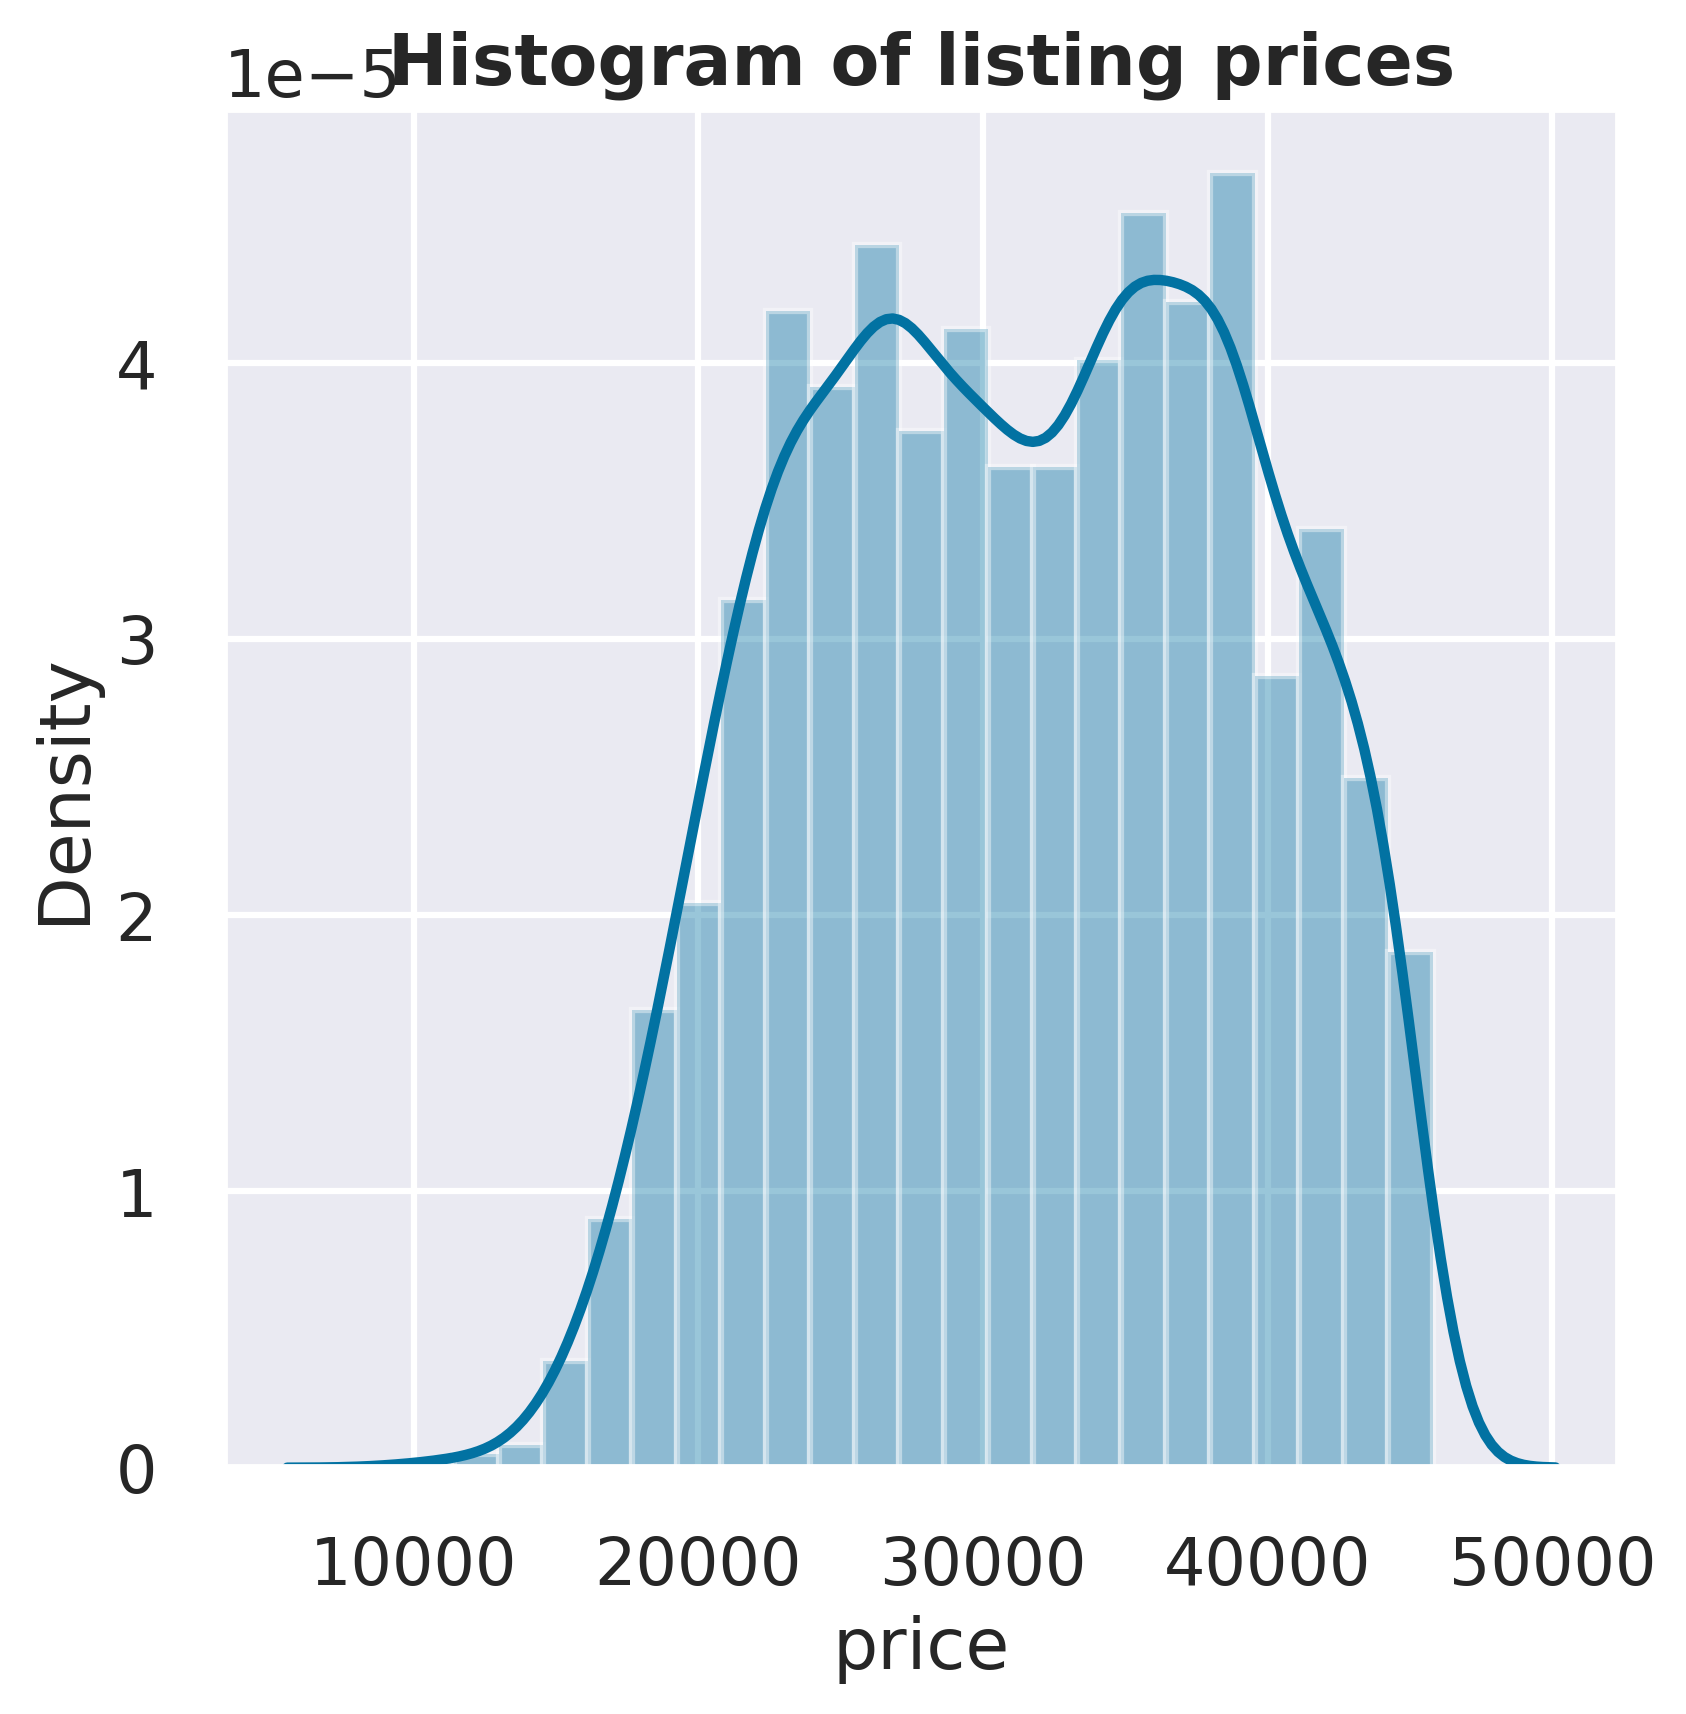

In [2]:
#collapse-hide
Image(filename='cpp/target_histogram.png',width=300, height=150)

<img src="cpp/target_histogram_TX.png" alt="Drawing" style="width: 300px;"/>

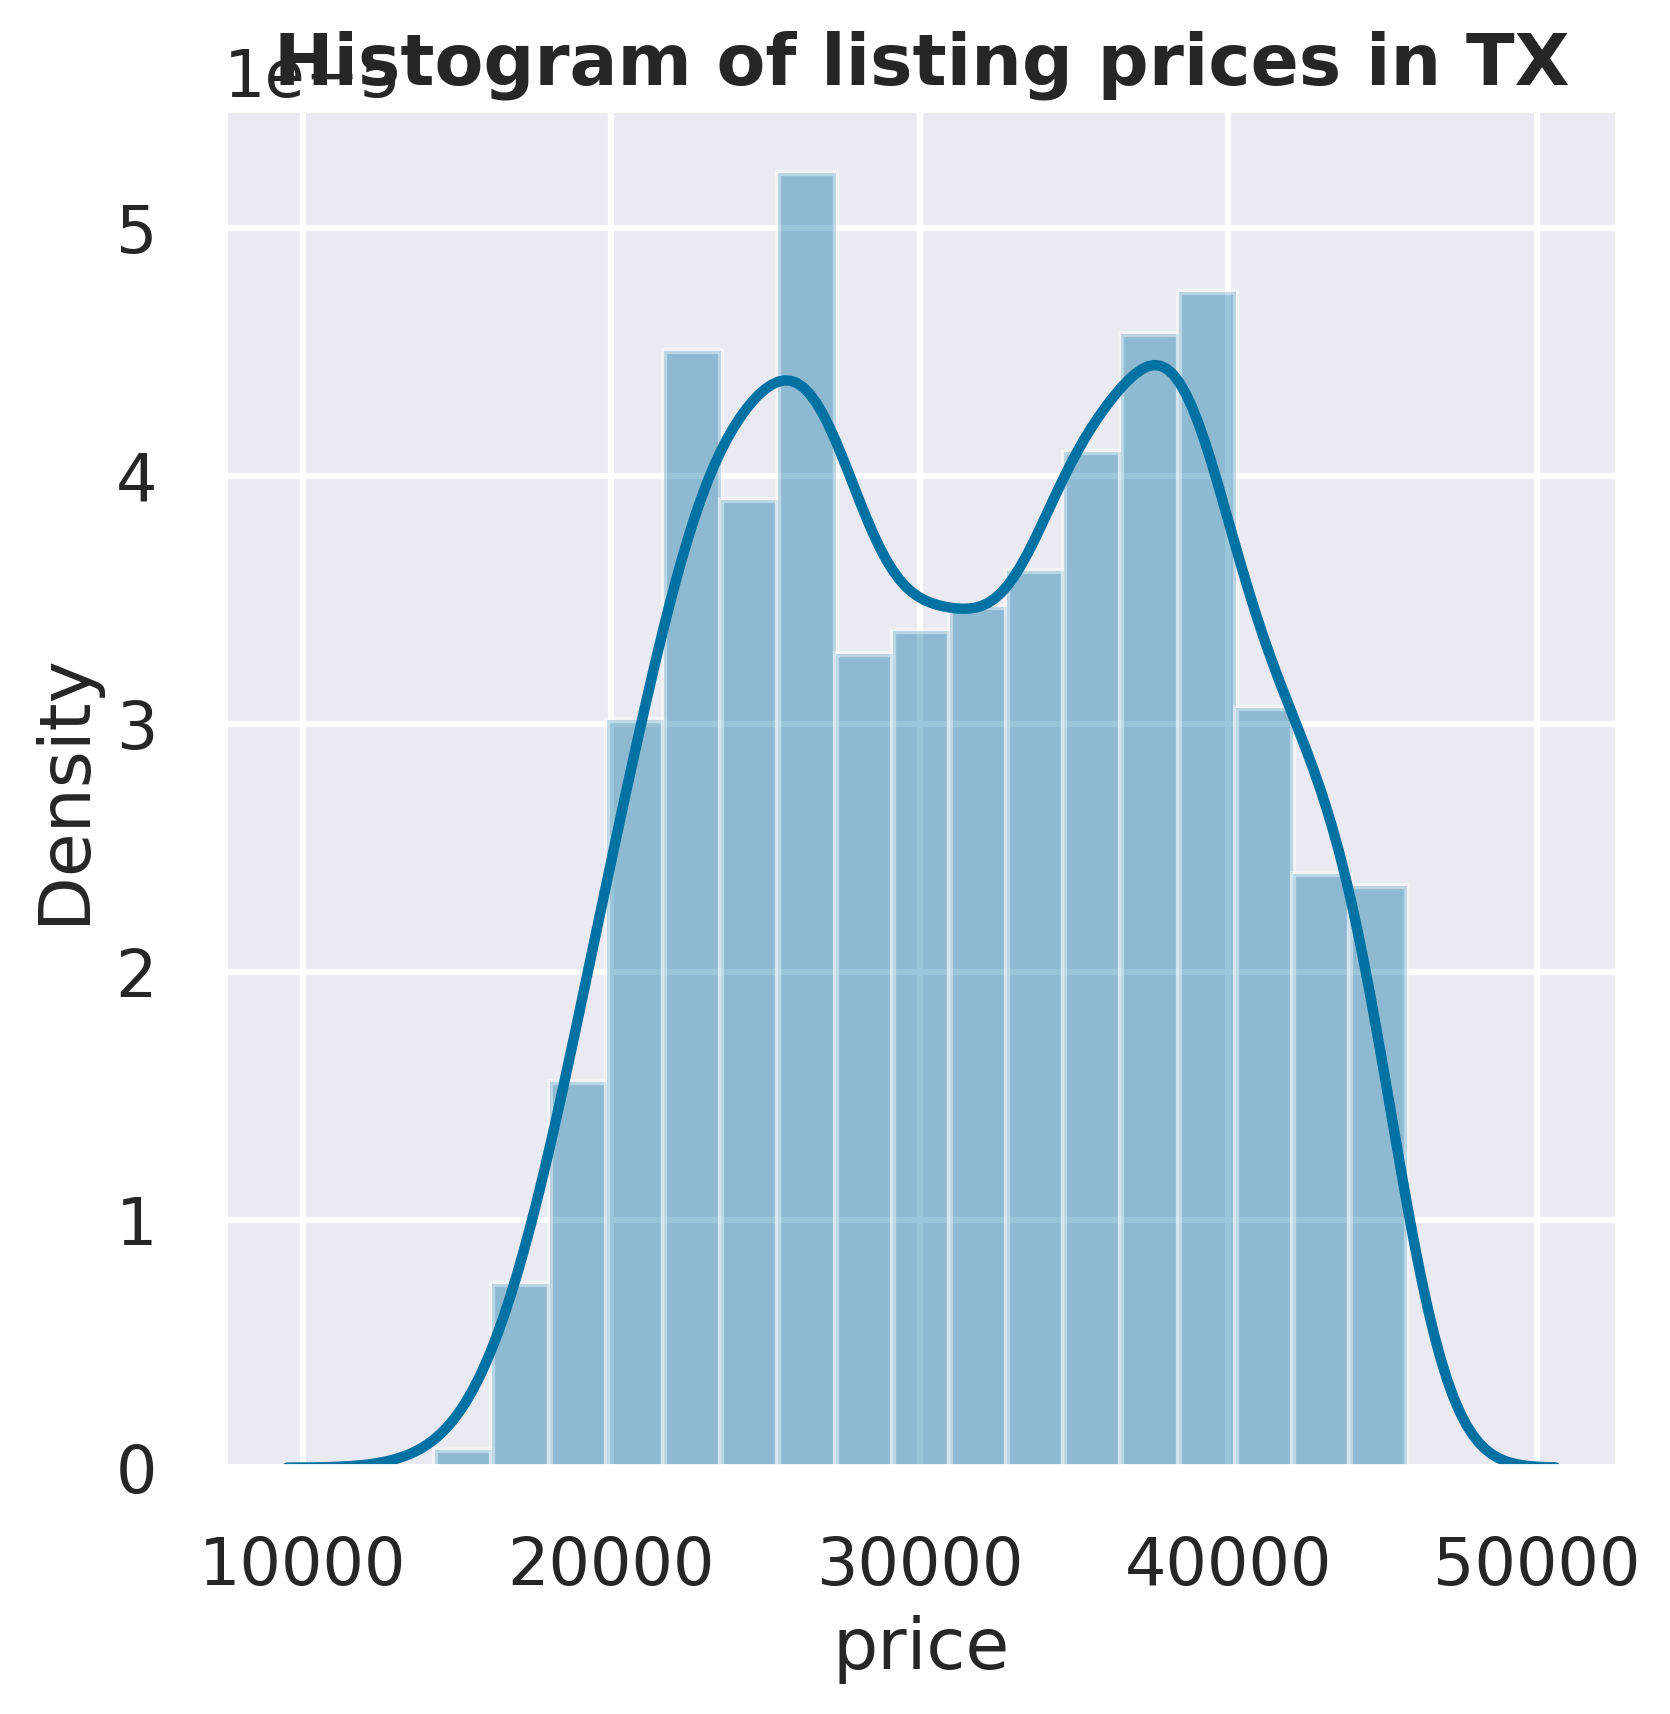

In [3]:
#collapse-hide
Image(filename='cpp/target_histogram_TX.png',width=300, height=150)

<img src="cpp/target_histogram_WA.png" alt="Drawing" style="width: 300px;"/>

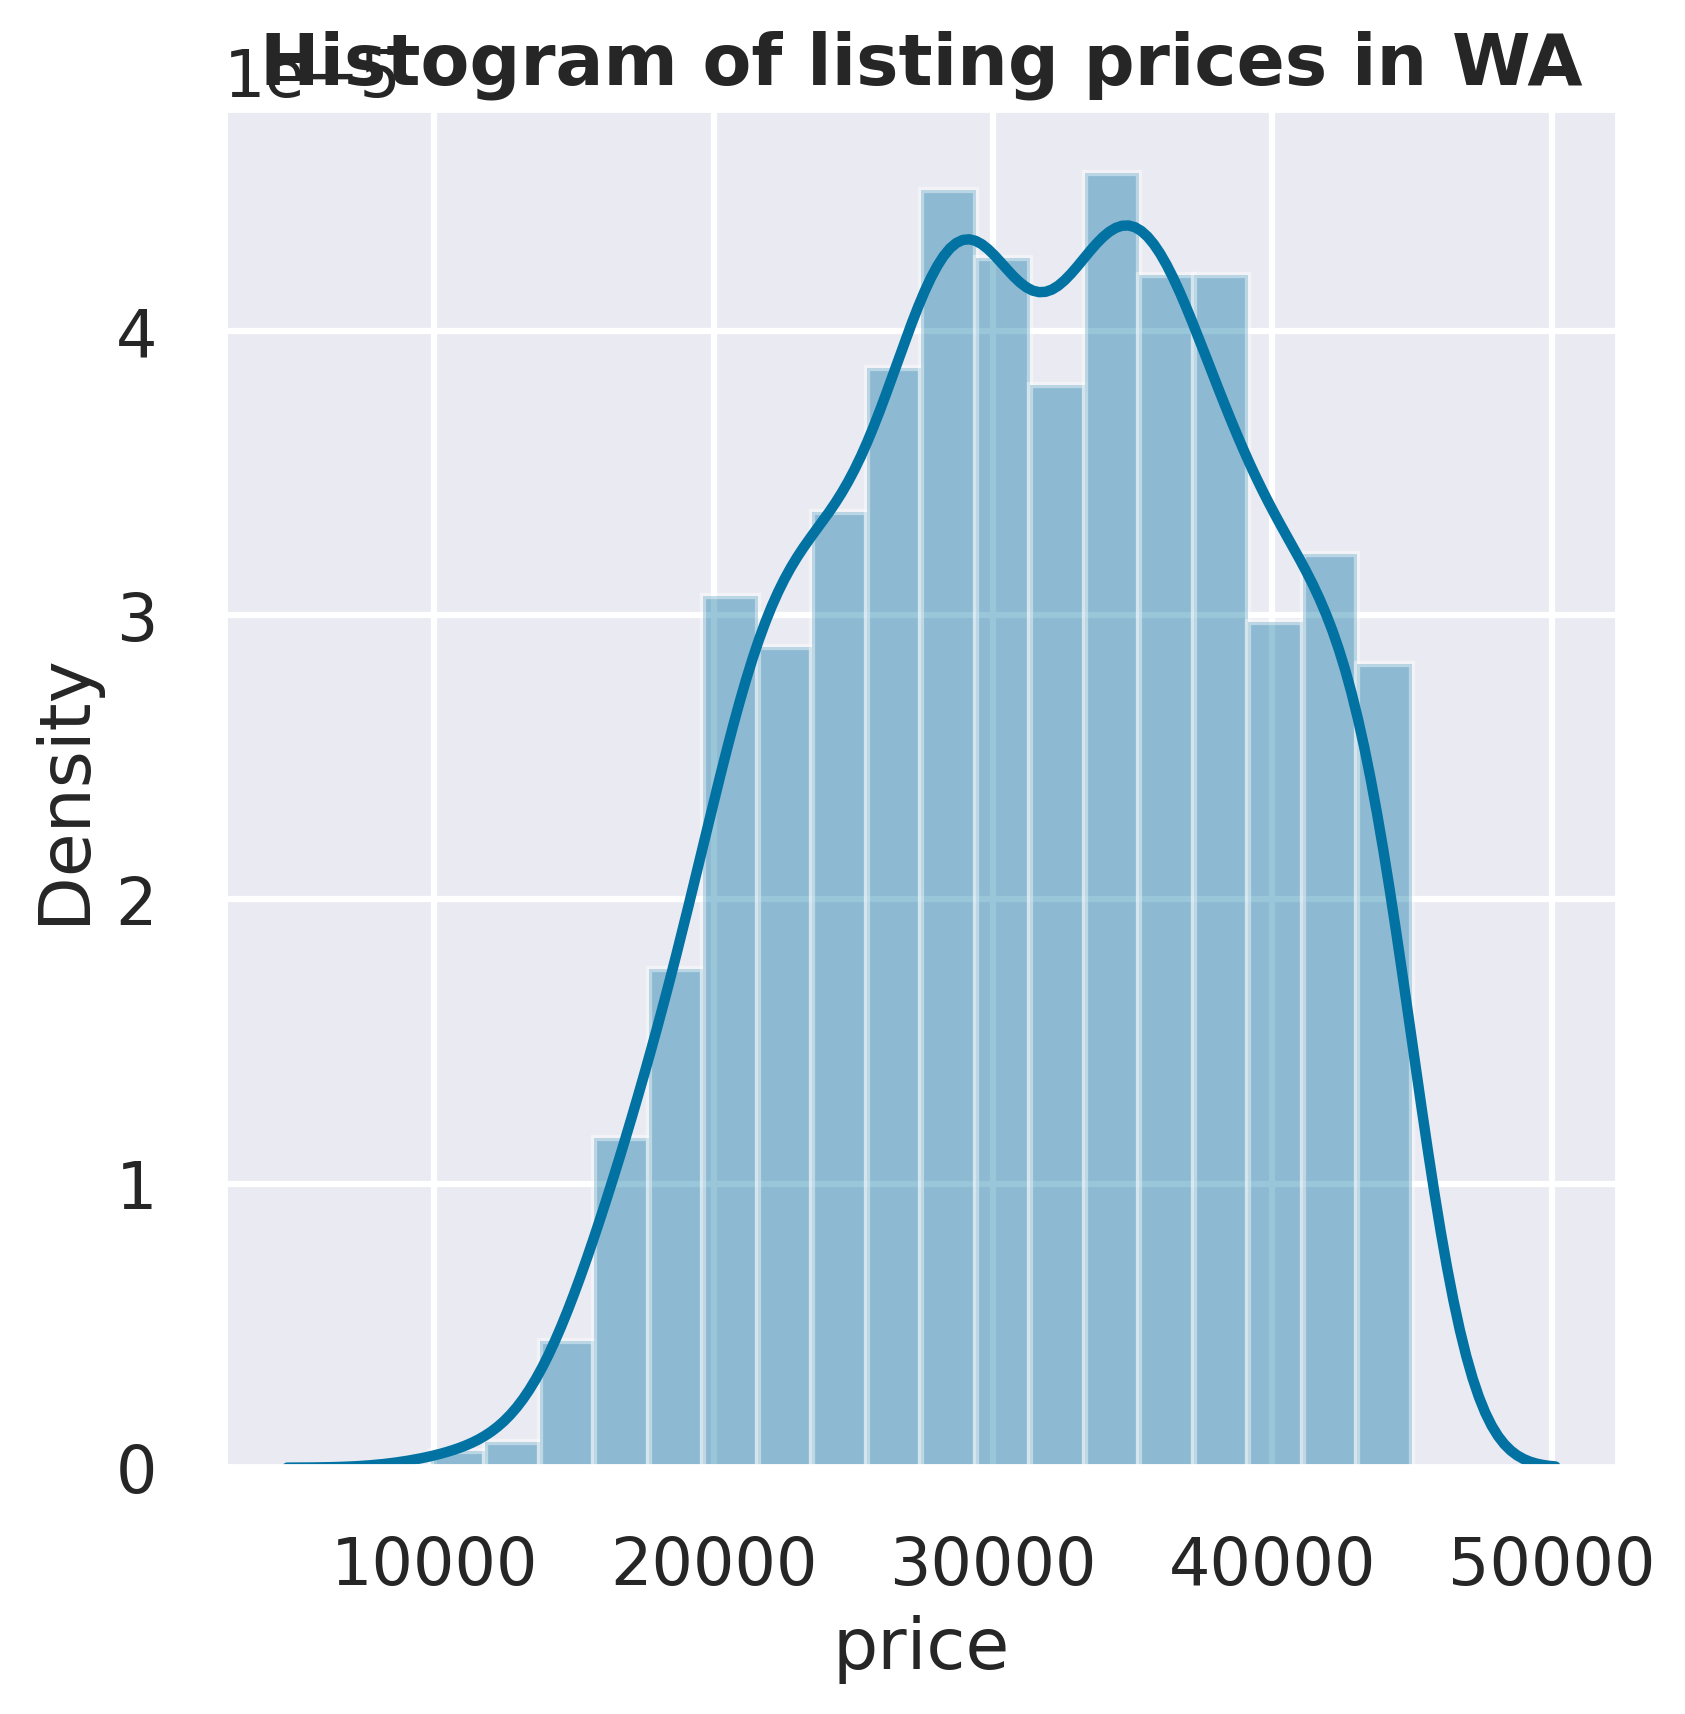

In [4]:
#collapse-hide
Image(filename='cpp/target_histogram_WA.png',width=300, height=150)

Since the target is a continuous variable, we would expect its histogram to follow a normal distribution, possibly with a few outliers on the low (left) or high (right) end of a bell-shaped curve. Although this observed target distribution for the overall training data is generally shaped similar to a normal distribution, it displays a (higher) tailing and a broader width for than expected.

A weak bimodal feature is present in the distribution. It was found that this was attributed more strongly to listings from the state of Texas than from Washington State. While we could filter the overall training data based to remove the bimodal feature, this would run the risk of introducing selection bias since we don't know the distribution of the test set or, more importantly, the distribution of data to be used for inference (if such a model were to be considered in a tool put into production).

So, for this iteration of the analysis, the raw `price` target data, and its not quite normally distributed values, was used. This could also be further investigated by scraping more data to determine if the two apparent peaks can be more clearly separated.

### Feature Exploration (brief) and Filtering Outliers

We'll first de-select rows where the numerical feature `per_month_min` is zero. These correspond to listings where the monthly payment is listed as zero dollars. It is clear that the per_month_min financing option is determined from the listing price. So, is a perfect correlation to price.

#### Numerical Features

It was found that  only one of the scraped numerical feature, namely `MPG` (miles per gallon), was reasonably linear in its relationship to the listing price. This feature required filtering to remove outliers above approx. 120 MPG and improve the linear relationship between `MPG` and the `price` column. This will be especially helpful as the other numerical features do not show a linear trend, a requirement for a linear regression model. It seems likely that at best, they'll be weak predictors of the price.

<img src="cpp/multi_feature_plot__20201210-220233.png" alt="Drawing" style="width: 2048px;"/>

In [5]:
#hide
# Image(filename="cpp/multi_feature_plot__20201210-220233.png")

#### Categorical Features

In order to visualize the influence of categorical features, the strongest independent variable (`MPG`) is plotted against the listing price and grouped by each of these features separately, as shown below

<img src="cpp/single_feature_plot.png" alt="Drawing"/>

In [6]:
#hide
# Image(filename="cpp/single_feature_plot.png")

From the drivetrain plot, we can see that 4WD (top-left) and FWD (bottom-right) listings are almost separated by AWD. RWD also generally plots distinctly. A weaker, but still present, separation is seen for transmission speed, where 6-speed listings show some separation from the other options.

If filtering `MPG` by 80 MPG, we would notably separately give up
- all `Hybrid` and `Electric` (`Fuel Type`) vehicles
  - in particular, the electric vehicles, which plot distinctly from the other types in the data
- some `1` (single)-speed transmission cars

So, we're losing these as factors to explain price in the ML model while improving the shape of the relationship between MPG and listing price. This is an acceptable tradeoff since there aren't many electric vehicles in the data and some single-speed listings remain after the filter is applied.

#### Summary of Applied Filters

The following filters were applied to the data to remove outliers
1. remove listings with greater than 120 MPG because there are only very few of these in the retrieved data and they introduce non-linearity in this feature which is the (visually) strongest predictor of price
2. remove listings with Mileage greater than 20 miles on the odometer
3. remove listings with fewer consumer reviews than 200 consumer reviews
4. remove listings with fewer seller reviews than 1,200 consumer reviews

## Feature Pre-Processing and Selection

### Feature Selection - Remove Collinear Features
Feature and polynomial interactions were computed from these numerical features. In order to avoid the problem of multi-collinearity between features of a ML model, thereby preserving interpretability of the ML model's coefficients, the interaction and polynomial terms could not be used. Below are heatmaps of inter-feature and feature-target correlations with (top) and without (bottom) interaction and polynomial terms

<img src="cpp/corr_heatmap__20201210-213628.png" alt="Drawing" style="width: 750px;"/>

In [7]:
#hide
# Image(filename='cpp/corr_heatmap__20201210-213628.png',width=750, height=250)

<img src="cpp/corr_heatmap__20201210-213629.png" alt="Drawing" style="width: 450px;"/>

In [8]:
#hide
# Image(filename='cpp/corr_heatmap__20201210-213629.png',width=450, height=150)

These heatmaps show why such terms were not be used here. There was a fifth scraped numerical feature - tank volume - but this was strongly correlated to MPG and so only one of these could be retained. It was decided to keep MPG and so tank volume was dropped.

### Pre-Processing - Transforming Continuous Features
Numerical features were transformed, to allow for a better fitting linear model. Linear models assume that continuous features follow a Gaussian (bell curved) distribution and the absence of this shape can make ML modeling challenging. From exploring the data, the strongest linear relationship to the price was found to be the Miles Per Gallon (`MPG`) variable, whose distribution is shown below

<img src="cpp/single_feature_multi_transformations__20201210-212350.png" alt="Drawing" style="width: 600px;"/>

In [9]:
#hide
# Image(filename='cpp/single_feature_multi_transformations__20201210-212350.png',width=600, height=200)

This feature is the combination of Highway MPG and City MPG. It is not a perfect Gaussian in shape. Several feature transformations were individually used to trye to improve this, and are shown in the graph. They were [Yeo-Johnson](https://www.jstor.org/stable/2673623?seq=1), [Box-Cox](https://rss.onlinelibrary.wiley.com/doi/10.1111/j.2517-6161.1964.tb00553.x), log-scaling and Quantile (mapping the probability distribution of a variable that of another distribution) transformations. Transformations do improve the shape of this feature's distribution. So, it was worth comparing different transformation types for this feature to see how they help in scoring predictions on data not seen during training of the ML model. This is the first step in the ML pipeline.

Of the four numerical features available in the scraped data, the other three variables used here displayed a non-Gaussian like distribution and so they were similarly transformed before quantitative ML modeling.

### Pre-Processing - Standardize Continuous Features
The next step was to standardize and [one-hot encode](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)#cite_note-G_&_S-1) numerical and categorical features respectively. [Scaling is required for some ML models in order that](https://en.wikipedia.org/wiki/Feature_scaling) the scale of different features does not affect the ML model. Linear models do not require features to be scaled. The type of scaling used here was standardization which transforms a variable such that it has a mean of 0 and a standard deviation of 1.i.e. subtracting the mean from the variable and dividing by the standard deviation.

With the exception of `MPG`, the other three numerical features were not close enough to a Gaussian distribution (a requirement of standardization), even after transformation. However, since only four numerical features were available, and since we're building a regression ML model here, these three features were retained in this iteration of model development.

This was the second step of the pipeline.

### Feature Selection  - Categoricals
There were a total of 15 categorical features available. By sequentially adding one feature at a time and comparing the scores from the pipeline's predictions, the best performing set of categorical features were selected. This was the third step in the pipeline. This step changed depending on the number of categorical features included for assessment.

### Missing Data
The next step was to drop any rows with missing data for the current iteration of the ML model.

## Linear Regression Models
The next step of the pipeline was selecting and training a linear regression model training with hyper-parameter optimization. Only one family of regression models was used - linear models. Four linear models were compared - standard [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression), [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), [Lasso Regression](https://en.wikipedia.org/wiki/Lasso_(statistics)) and [Elastic Net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization). The last three of these involves applying a penalty to 

For the regression models that used it, the amount of regularization was tuned using the repeated 5-fold cross-validation procedure described above.

## ML Pipeline Comparison
The scoring of ML pipeline predictions mentioned above was done using [5-fold Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation), with five repeats Five cross-validation folds were generated - these are different two-way divisions of the overall training data into a training split and a validation split. The pipeline was trained on each fold's training split, and then used to make predictions on the corresponding testing split. This was repeated five times per 5-fold cross-validation. This process was repeated five times, with different divisions created pre repetition. The predictions were scored against the true values of the car price using the RMSE metric, as mentioned above. The stability of ML model coefficients was also compared to ensure that these values did not change dramatically as transformations and/or features were added.

## Results of Selecting the Best Pipeline
Using only the small number of available numerical (continuous) features, the best RMSE found was approximately `$`6,000. This means the best ML model could predict listing price within `$`6,000 of the true value, which is larger than the threshold of `$`5,000 set out by the client for this pricing service. With this in mind, categorical features were added and the scoring metric (RMSE) improved to approx. `$`4,800, which is now within the required threshold.

The best pipeline was comprised of
- four numerical features being transformed using the Yeo-Johnson transformation and then standardized
- eight of the 15 categorical features being selected and then one-hot encoded
  - after encoding, approximately 35 categorical features were generated, in combination with the four numerical features
- Ridge Regression ML model with tuned penalty hyper-parameter
  - Ridge was chosen over Lasso and Elastic Net, although scores from these two approaches were very similar to the Ridge approach. The Linear Regression model coefficients and scores were unstable and occassionally returned very large values. For this reason, it was not used.

## Interpreting the ML Model's Predictions

For subsequent sections, the best ML pipeline found above will be referred to as the ML model.

We'll take a look at the car features that were found to be the most important to the ML model's predictors on unseen data. Below are the ML model's coefficients, followed by the permutation importances

<img src="cpp/coefs__20201210-213631.png" alt="Drawing" style="width: 750px;"/>

In [10]:
#hide
# Image(filename='cpp/coefs__20201210-213631.png',width=750, height=250)

<img src="cpp/bar_box_plot_train.png" alt="Drawing"/>

In [11]:
#hide
# Image(filename='cpp/bar_box_plot_train.png')

<img src="cpp/bar_box_plot_test.png" alt="Drawing"/>

In [12]:
#hide
# Image(filename='cpp/bar_box_plot_test.png')

The larger the magnitude of the feature's coefficient or permutation importance, the greater the importance of that feature to the ML model's predicted listing price.

Not surprisingly, the Miles Per Gallon is found to be the most dominant value-add variable to the ML model on both data it had and had not seen before. The correlation between the price and miles per gallon (also a continuous variable) was seen earlier, so we'd expect the model to draw on this relationship when making predictions.

Another feature which showed up frequently as a value add and detractor to the listing price was the transmission speed. Recalling the exploratory data analysis section, and recalling that single-speed and Automatic transmission cars were generally separated from the other transmission types, we see that the ML model has unsurprisingly indicated that this to be an important factor in predicting the car's sale price.

Very similar observations to those for transmission speed can be made for Drive Train - another strong predictor of car price. There is delineaetion between the categories within this feature on the plot of Price against Miles Peg Gallon.

Across both ML model coefficient importance and feature permutation importance, interior design features prominently. We can think of this as follows: people are going to interact more with the inside of the car than the outside. If people only see the outside of the car, most won't want to pay as much because their opinion will change once they have seen the inside. The quality of the material used on the seats, the dashboard, floor mats, central console organizer - relatively speaking, these are far more frequently encountered by an owner during daily use than the style of the exterior of the car. Now, if these were all luxury cars, then this reasoning could change.

These features mentioned above drop in their relative predictive power for incorrect predictions (those that are outside our acceptable threshold), but still remain among the strongest predictors of the listing price. This further points to their importance to the ML model's predictions of car price.

## Prediction Errors

### Predicted Compared to True Price

The best ML model's prediction error is shown below - this is the predicted price plotted against the observed price

<img src="cpp/yb_pred_error__20201210-214245.png" alt="Drawing" style="width: 750px;"/>

In [13]:
#hide
# Image(filename='cpp/yb_pred_error__20201210-214245.png',width=750, height=250)

The model generally over-predicts lower priced listings and under-predicts higher priced ones. As mentioned earlier, the client placed a higher penalty on the incorrect and under-predicted listings and it is not surprising that this ML model's performance results in us making a loss on unseen data. This observation from the prediction error plot suggests that the effect of the variables scraped from cars.com on the listing price is not intrinsically linear. This was also noted during the exploratory data analysis section where the miles per gallon was found to be the sole continuous variable with a clear linear relationship to the listing price. Further, the majority of features are categorical and not continuous. Linear regression ML models depend on such numerical, or continuous, features to anchor their ability to make predictions.

In order to deal with these listings, it may be necessary to extract additional features from the scraped data, perhaps from the unused text columns (the text of the customer reviews, or the description of the listing, etc.) or assign sub-groups to some of the high-cardinality features that were excluded such as Interior or Exterior Color, Model, etc. We could also move to a non-linear regression model and indeed, as was seen from the ML model's learning curves, a tree-based ensemble model was found to improve (reduce) the error in the predictions. If we could retrieve the date or month of the year, we could also consider including a broad market indicator such as gas price or [personal loan interest rate, from the US Federal Reserve St. Louis](https://fred.stlouisfed.org/series/TERMCBPER24NS) as an approximate surrogate for asset valuation.

### Difference between Predicted and True Price

The ML model's prediction residual (the difference between predicted and true price in unseen test data) is shown below

<img src="cpp/multi_histograms__20201210-213633.png" alt="Drawing" style="width: 900px;"/>

In [14]:
#hide
# Image(filename='cpp/multi_histograms__20201210-213633.png',width=900, height=300)

While generally both display the expected Gaussian profile, the test set (unseen during ML model training) produced higher-than-expected under-prediction errors in the `$`5,000-`$`10,000 range. While this effect is seen for the overall training data, accounting for the wider-than-[expected tailing](https://en.wikipedia.org/wiki/Gaussian_function#/media/File:Normal_Distribution_PDF.svg) observed, the residual is higher in this range for the testing data. As mentioned earlier, these under-predicted errors are the more strongly penalized errors by the client and will contribute negative returns when deploying this ML model as part of a car pricing service.

Plotting the ML model's prediction residual by state showed no eviden pattern (see below), which is re-assuring since the client is targeting customers in the vicinity of two cities, as shown below

<img src="cpp/Residuals_by_Predicted Value__20201210-213941.png" alt="Drawing" style="width: 750px;"/>

In [15]:
#hide
# Image(filename='cpp/Residuals_by_Predicted Value__20201210-213941.png',width=750, height=250)

> Warning: if, during the eploratory data anlysis, we observed a strong enough difference, then developing a separate ML model per state might have been warranted

## Cost of ML model's prediction errors

With the model exhibiting acceptable performance, a last step in the ML development for this project was to estimate the cost we would incur by putting this model into production as part of the aforementioned pricing service. To do this, it was necessary to estimate to financial cost of prediction errors made by the model.

### In-Range predictions
It is possible that the model could make a prediction within the range of `$`5,000 above or below the true price of the listing. This satisfies the client's requirements and we earn a return from them for every prediction made that falls in this tolerable range. However, if the predictions are outside this range, then the two resulting errors are not equal in the eyes of the client. They'll be using these predictions as part of their financing service and the options they offer their customers change based on whether the predicted listing price is over-estimated or under-estimated.

### Unequal cost of errors
A customer would prefer that the true cost of a car they want to purchase be over-predicted (meaning they would have to pay less, when eventually purchasing) than under-predicted (they have to pay an additional amount when purchasing). However, the client has prepared a financing offer based on the predicted price. If this is different from the true price, then this offer has to eventually change when the custome contacts them looking to proceed with the purchase. How this financing package changes depends on whether the true price is under- or over-predicted by our ML price predition model.

With an under-prediction, the customer has to pay more and then re-negotiates the financing with our client, possibly getting a better deal.i.e. our client has to make a more generous offer than initially planned in order to keep their customer happy and proceed with the purchase. So, they will penalize us more for such under-predictions than for our ML model's over-predictions.

### Assumed penalty structure
The following assumptions are made about these penalties for predictions outside the tolerable range
- under-predictions cost us 40%  of the difference between predicted and true price
- over-predictions cost us 15% of the difference
- for in-range predictions, we earn 10% of the true price of the listing

### Estimated Cost

With the above penalty structure in place, we can approximate our (gross) return on the ML model's predictions (GR) in production using

GR = ( P<sub>U</sub> X R ) + ( P<sub>O</sub> X R ) + ( E<sub>IR</sub> X R )

where
- R = y<sub>P</sub> - y<sub>T</sub> is the difference between predicted (y<sub>P</sub>) and true (y<sub>T</sub>) price
- P<sub>U</sub> is the penalty for under-prediction (-40%)
- P<sub>O</sub> is the penalty for over-prediction (-15%)
- E<sub>IR</sub> is the earning (reward) for in-range prediction (+10%)

Using this equation, we can estimate our return on each prediction in the test set (unseen data). We can also calculate the median return per listing prediction and the total return over all the predictions made.

With 78 wrong under-predictions, 61 wrong over-predictions and the remaining as in-range (tolerable) predictions on the unseen data, the median return was estimated to be a loss of `$`1,240 per listing and the total return was estimated to be a loss of `$`77,000.

If we did not use an ML-based approach, then we could have offered a pricing service where we simply guessed that the price of every new listing (in the test set) would be the average (mean) of the prices in the overall training data. Using this naive strategy, our median return is estimated to be a loss of `$`1,960 per listing and an overall loss of `$`271,406 is incurred. Similarly, we could have used a different strategy where we replaced the mean of the training data prices by the median of the prices. Below is a summary of the costs incurred by the ML-based and these two naive approaches

In [16]:
#collapse-hide
display(
    pd.DataFrame.from_records(
        [
            {"median ($)": -1241, "sum ($)": -77_520},
            {"median ($)": -2089, "sum ($)": -291_604},
            {"median ($)": -1961, "sum ($)": -271_407},
        ],
    ).set_index([["ML", "Naive_Median", "Naive_Mean"]]).style.format(
        "{:,.0f}"
    ).set_caption(
        "Returns from ML-based Pricing Service"
    )
)

,median ($),sum ($)
ML,"-1,241","-77,520"
Naive_Median,"-2,089","-291,604"
Naive_Mean,"-1,961","-271,407"


where the `median` column is the median return per price prediction made by our ML model (first row) or naive approaches (second and third rows). The `sum` column is the total return over all predictions made.

Although we are saving by developing an ML-model to make these predictions, rather than naive guessing, the current performance of the ML model will nonetheless result in an overall loss. The penalty assigned to the ML model's over- or under-estimations is the dominant factor. There are approx. 38% under-predictions outside the client's tolerable range and this dominates the reward for the approx. 62% tolerable under-predictions. Similarly, the penalty assigned to 28% of wrong over-predictions are dominating the 72% tolerable over-predictions.

## Conclusion

After filtering to remove outliers from listings scraped from cars.com (where the max. prices is capped at `$`45,000), selecting features and choosing between four types of linear regression models, the best ML model was trained on approx. 1,800 listings from cars.com and made 428 predictions on data not seen during ML model development. The best ML model here returns an RMSE, on the predictions, of approx. `$`4,900 (R<sup>2</sup> = 0.61). This meets the goal for this project. The factors most important to the model;s ability to predict unseen data are MPG, Drivetrain, Transmission Speed and Interior design, the latter three of which are categorical features.

However, if the best linear ML model found here is deployed as part of a price prediction service to make these predictions on unseen data, then offering such a service will cost us (rather than generate returns) due to the heavily penalized under-predicted prices at the current level of performance.

## Looking Ahead

There are several next steps that can be followed in order to attempt at improving the current ML model performance. A few options related to the feature engineering might warrant consideration.

A logical starting point is to look into improving results on the worst under-predicted listings. These were predominantly from WA state and were priced above the price of listings used to train the ML model. Adding a market indicator as a proxy for asset valuation could be explored to account for the pattern of these errors in relation to listing price. Additng demographic data that separates the two states, in the vicinity of the client's targeted cities, could be explored to account for the dependence on the state.

A few high-cardinality categorical features were left out. These could be aggregated so that infrequently occurring categories are binned together. This could help reduce the cardinality of the feature while also making the feature usable without causing an explosion in the number of features after encoding. Ofcourse, the drawback is that some of the predictive power of the binned categories could be lost.

Given the dearth of numerical features linearly related to the listing price, scraping new vehicle attributes from cars.com (for the same listings) could be pursued. Also, text attributes have not been used, such as a description of the vehicle. One could attempt to extract named entities or topics from this text and augment the exising data.